In [1]:
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import sklearn.ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
# import eli5
# from eli5.sklearn import PermutationImportance

%matplotlib inline

C:\Users\csong\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# machine learning
import warnings

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, r2_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from boruta import BorutaPy
from xgboost import XGBClassifier, XGBRanker
from scipy.stats import skew


# print(__doc__)

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
## Load the data set that got dummified to process feature selection.
train= pd.read_csv('./data/Xing/unique_train_cleaned_25.csv')
test= pd.read_csv('./data/Xing/unique_test_cleaned_25.csv')

X_train= train.drop(['readmitted','encounter_id','patient_nbr'], axis=1)
y_train= train['readmitted']



X_test = test.drop(['readmitted','encounter_id','patient_nbr'], axis=1)
y_test = test['readmitted']


print("Dataset: Unique- Drop Patient encounter ID")
print('The shape of the unique train dataset {}'.format(train.shape))
print('The shape of the unique test dataset  {} '.format(test.shape))

Dataset: Unique- Drop Patient encounter ID
The shape of the unique train dataset (55815, 94)
The shape of the unique test dataset  (22049, 94) 


# Logistic Regression

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(fit_intercept=True, penalty='l1')
logreg.fit(X_train, y_train)
print("Train set Score: {:.2%}".format(logreg.score(X_train, y_train)))
print("Test Set score : {:.2%}".format(logreg.score(X_test, y_test)))

Train set Score: 91.93%
Test Set score : 90.14%


- Highly overfitting.

In [5]:
y_test_predict = logreg.predict(X_test)

In [6]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,19853,27,19880
1,2148,21,2169
All,22001,48,22049


In [7]:
# Print Classification Report
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.90      1.00      0.95     19880
          1       0.44      0.01      0.02      2169

avg / total       0.86      0.90      0.86     22049



In [82]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

8 17 2161 19863


In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.901
Precision is 0.320
Recall is 0.004
AUC is 0.501
TPR is 0.004
FPR is 0.001
TNR is 0.999


In [10]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

In [11]:
coef_base=pd.DataFrame(zip(X_train.columns, np.transpose(logreg.coef_)),columns=['Features','Coefficients']).sort_values(by='Coefficients',ascending=False)

In [12]:
coef_base.head(10)

,Features,Coefficients
69,rosiglitazone_Up,[0.37723773559659207]
21,discharge_disposition_id_hospital,[0.34607977492964853]
7,number_inpatient,[0.3397669467586342]
90,diabetesMed_Yes,[0.3023680557776291]
61,glyburide_Steady,[0.20081384351322545]
37,max_glu_serum_Norm,[0.17185268918128252]
17,admission_type_id_na,[0.14915791368053885]
39,A1Cresult_None,[0.13373360611726817]
9,med_dosage_change,[0.12168609983203839]
36,max_glu_serum_None,[0.07653538447250384]


#### Summary( Base Logistic Regression):
  - Classification Error Type II --> The data distribution has highly unbalance between among the train dataset. Thus, we apply SMOTE.

#### Apply SMOTE

In [13]:
# Data balancing applied using SMOTE
from imblearn.over_sampling import SMOTE

from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=20)
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train_SMOTE)))

Original dataset shape Counter({0: 51329, 1: 4486})
New dataset shape Counter({0: 51329, 1: 51329})


In [14]:
#Put the new balanced dataset (Oversampled with SMOTE) in the dataframe
X_train_SMOTE = pd.DataFrame(X_train_SMOTE, columns = list(X_train.columns))

In [15]:
# Run the crossvalidation following by fit the SMOTE balanced data

logreg = LogisticRegression(fit_intercept=True, penalty='l1')
logreg.fit(X_train_SMOTE, y_train_SMOTE)
print("Train set Score: {:.3%}".format(logreg.score(X_train_SMOTE, y_train_SMOTE)))
print("Test Set score : {:.3%}".format(logreg.score(X_test, y_test)))

Train set Score: 63.437%
Test Set score : 63.073%


In [16]:
# Check with the validation testset
y_test_predict = logreg.predict(X_test)
probability = logreg.predict_proba(X_test)

In [17]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,12727,7153,19880
1,989,1180,2169
All,13716,8333,22049


In [18]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.93      0.64      0.76     19880
          1       0.14      0.54      0.22      2169

avg / total       0.85      0.63      0.71     22049



In [19]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

1180 7153 989 12727


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.631
Precision is 0.142
Recall is 0.544
AUC is 0.592
TPR is 0.544
FPR is 0.360
TNR is 0.640


In [21]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

#### Apply 'Class_weight' = balanced

In [22]:
# Turn on Class-weight balance

logreg = LogisticRegression(fit_intercept=True, penalty='l1',class_weight='balanced')
logreg.fit(X_train_SMOTE, y_train_SMOTE)
print("Train set Score: {:.3%}".format(logreg.score(X_train_SMOTE, y_train_SMOTE)))
print("Test Set score : {:.3%}".format(logreg.score(X_test, y_test)))

Train set Score: 63.440%
Test Set score : 63.069%


In [23]:
# Check with the validation testset
y_test_predict = logreg.predict(X_test)
probability = logreg.predict_proba(X_test)

In [24]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,12726,7154,19880
1,989,1180,2169
All,13715,8334,22049


In [25]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.93      0.64      0.76     19880
          1       0.14      0.54      0.22      2169

avg / total       0.85      0.63      0.71     22049



In [26]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

1180 7154 989 12726


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.631
Precision is 0.142
Recall is 0.544
AUC is 0.592
TPR is 0.544
FPR is 0.360
TNR is 0.640


In [28]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

In [29]:
coef_SMOTE=pd.DataFrame(zip(X_train_SMOTE.columns, np.transpose(logreg.coef_)),columns=['Features','Coefficients']).sort_values(by='Coefficients',ascending=False)

In [30]:
coef_SMOTE.head(10)

,Features,Coefficients
72,acarbose_Up,[3.2388515080817624]
69,rosiglitazone_Up,[1.0476717082549778]
68,rosiglitazone_Steady,[0.9445593093446595]
46,repaglinide_Up,[0.6079866799344354]
67,rosiglitazone_No,[0.5841404953044774]
45,repaglinide_Steady,[0.5460220170121892]
90,diabetesMed_Yes,[0.5077250404363428]
61,glyburide_Steady,[0.4271980725963174]
7,number_inpatient,[0.42081488282641244]
21,discharge_disposition_id_hospital,[0.3907771122254104]


#### Apply RandomizedSearch

In [31]:
# Apply randomizedsearch to find the optimum "C"

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X_train_SMOTE, y_train_SMOTE)
search.best_params_


{'C': 2.4942547871438894, 'penalty': 'l2'}

In [32]:
logreg = LogisticRegression(fit_intercept=True, penalty='l1',class_weight='balanced',C=2.195254015709299)
logreg.fit(X_train_SMOTE, y_train_SMOTE)
print("Train set Score: {:.3%}".format(logreg.score(X_train_SMOTE, y_train_SMOTE)))
print("Test Set score : {:.3%}".format(logreg.score(X_test, y_test)))

Train set Score: 63.448%
Test Set score : 63.096%


In [33]:
# Check with the validation testset
y_test_predict = logreg.predict(X_test)
probability = logreg.predict_proba(X_test)

In [34]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,12732,7148,19880
1,989,1180,2169
All,13721,8328,22049


In [35]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.93      0.64      0.76     19880
          1       0.14      0.54      0.22      2169

avg / total       0.85      0.63      0.71     22049



In [36]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

1180 7148 989 12732


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.631
Precision is 0.142
Recall is 0.544
AUC is 0.592
TPR is 0.544
FPR is 0.360
TNR is 0.640


In [38]:
accuracy_logreg = accuracy_score(y_test, y_test_predict)
precision_logreg = precision_score(y_test, y_test_predict)
recall_logreg = recall_score(y_test, y_test_predict)
auc_logreg = roc_auc_score(y_test, y_test_predict)
TPR_logreg=TPR
FPR_logreg=FPR
TNR_logreg=TNR

In [39]:
coef_random_search=pd.DataFrame(zip(X_train_SMOTE.columns, np.transpose(logreg.coef_)),columns=['Features','Coefficients']).sort_values(by='Coefficients',ascending=False)

In [40]:
coef_random_search.head(10)

,Features,Coefficients
72,acarbose_Up,[3.7063642682664644]
69,rosiglitazone_Up,[1.1774695060051603]
68,rosiglitazone_Steady,[1.0264162794732743]
67,rosiglitazone_No,[0.7063129566975456]
46,repaglinide_Up,[0.6327661205581011]
45,repaglinide_Steady,[0.5129512671037519]
90,diabetesMed_Yes,[0.5079169147223117]
7,number_inpatient,[0.4210274399479782]
61,glyburide_Steady,[0.40878201904448874]
21,discharge_disposition_id_hospital,[0.3911925151894585]


In [41]:
# import statsmodels.api as sm
# logit = sm.Logit(X_train_SMOTE, y_train_SMOTE)

# result = logit.fit()
# print(result.summary())

# Decision Tree Clssifier - "Entropy"

- For this decision tree classifier, I developed the model based on the reference model (logistic regression with SMOTE)

In [42]:
# Data balancing applied using SMOTE
from imblearn.over_sampling import SMOTE

from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=20)
X_train_SMOTE_dt, y_train_SMOTE_dt = sm.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train_SMOTE_dt)))

Original dataset shape Counter({0: 51329, 1: 4486})
New dataset shape Counter({0: 51329, 1: 51329})


In [43]:
from sklearn.tree import DecisionTreeClassifier
dt_en = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dt_en.fit(X_train_SMOTE_dt, y_train_SMOTE_dt)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=28,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
print("Train set Score: {:.3%}".format(dt_en.score(X_train, y_train)))
print("Test Set score : {:.3%}".format(dt_en.score(X_test, y_test)))

Train set Score: 95.530%
Test Set score : 85.278%


In [45]:
y_test_predict = dt_en.predict(X_test)

In [46]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,18578,1302,19880
1,1944,225,2169
All,20522,1527,22049


In [47]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.91      0.93      0.92     19880
          1       0.15      0.10      0.12      2169

avg / total       0.83      0.85      0.84     22049



In [48]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

225 1302 1944 18578


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.853
Precision is 0.147
Recall is 0.104
AUC is 0.519
TPR is 0.104
FPR is 0.065
TNR is 0.935


In [50]:
accuracy_dt_en = accuracy_score(y_test, y_test_predict)
precision_dt_en = precision_score(y_test, y_test_predict)
recall_dt_en = recall_score(y_test, y_test_predict)
auc_dt_en = roc_auc_score(y_test, y_test_predict)
TPR_dt_en=TPR
FPR_ldt_en=FPR
TNR_dt_en=TNR

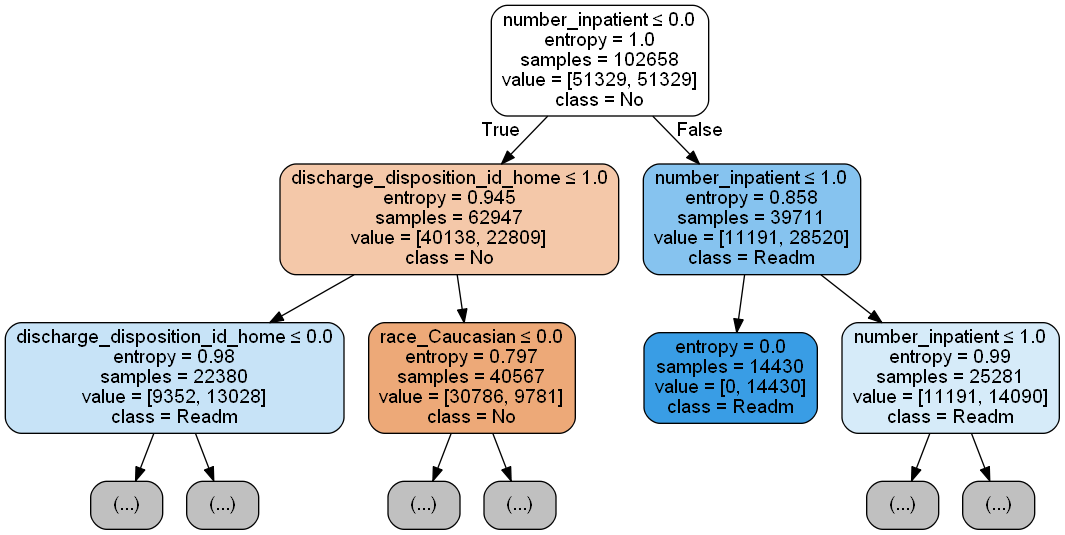

In [51]:
# Visualizaing decision tree for Question 2 - detailed feature set
import graphviz
from IPython.display import Image
import pydotplus
from sklearn import tree
dot_dt_q2 = tree.export_graphviz(dt_en, out_file="dt_q2.dot", feature_names=X_train.columns, max_depth=2,
                                 class_names=["No","Readm"], filled=True, rounded=True, special_characters=True)
graph_dt_q2 = pydotplus.graph_from_dot_file('dt_q2.dot')
Image(graph_dt_q2.create_png())

                          Feature  Importance
1                time_in_hospital       0.018
22    discharge_disposition_id_na       0.018
80                 insulin_Steady       0.026
79                     insulin_No       0.026
4                 num_medications       0.027
2              num_lab_procedures       0.034
12                 race_Caucasian       0.073
16                    gender_Male       0.091
20  discharge_disposition_id_home       0.167
7                number_inpatient       0.297


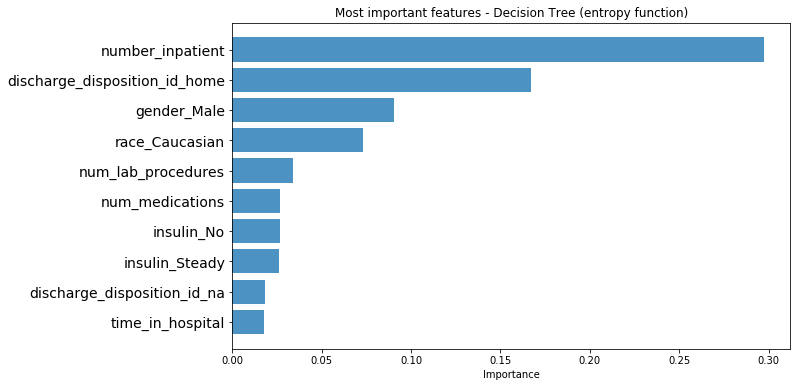

In [52]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dt_en.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree (entropy function)')
plt.show()

# Decision Tree Classifier : "Gini"

In [53]:
from sklearn.tree import DecisionTreeClassifier
dt_g = DecisionTreeClassifier(max_depth=28, criterion = "gini", min_samples_split=10)
dt_g.fit(X_train_SMOTE_dt, y_train_SMOTE_dt)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=28,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
print("Train set Score: {:.3%}".format(dt_g.score(X_train_SMOTE_dt, y_train_SMOTE_dt)))
print("Test Set score : {:.3%}".format(dt_g.score(X_test, y_test)))

Train set Score: 97.165%
Test Set score : 85.972%


In [55]:
y_test_predict = dt_g.predict(X_test)

In [56]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,18758,1122,19880
1,1971,198,2169
All,20729,1320,22049


In [57]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.90      0.94      0.92     19880
          1       0.15      0.09      0.11      2169

avg / total       0.83      0.86      0.84     22049



In [58]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

198 1122 1971 18758


In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.860
Precision is 0.150
Recall is 0.091
AUC is 0.517
TPR is 0.091
FPR is 0.056
TNR is 0.944


In [60]:
accuracy_dt_g = accuracy_score(y_test, y_test_predict)
precision_dt_g = precision_score(y_test, y_test_predict)
recall_dt_g = recall_score(y_test, y_test_predict)
auc_dt_g = roc_auc_score(y_test, y_test_predict)

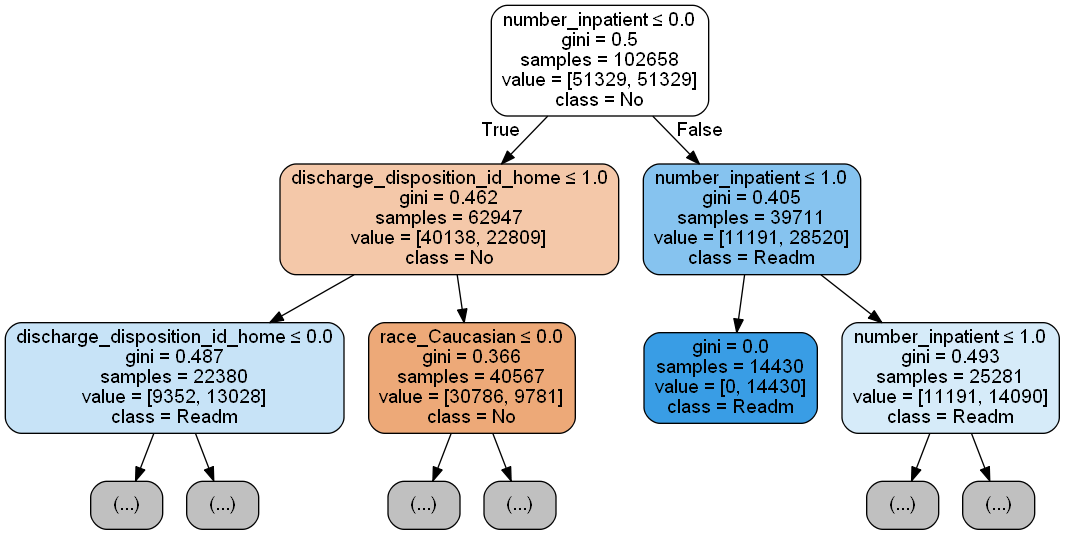

In [61]:
# Visualizaing decision tree for Question 2 - detailed feature set
import graphviz
from IPython.display import Image
import pydotplus
from sklearn import tree
dot_dt_q2 = tree.export_graphviz(dt_g, out_file="dt_q2.dot", feature_names=X_train.columns, max_depth=2,
                                 class_names=["No","Readm"], filled=True, rounded=True, special_characters=True)
graph_dt_q2 = pydotplus.graph_from_dot_file('dt_q2.dot')
Image(graph_dt_q2.create_png())

                          Feature  Importance
4                 num_medications       0.016
57                   glipizide_No       0.018
2              num_lab_procedures       0.018
80                 insulin_Steady       0.020
22    discharge_disposition_id_na       0.020
9               med_dosage_change       0.030
12                 race_Caucasian       0.080
16                    gender_Male       0.099
20  discharge_disposition_id_home       0.189
7                number_inpatient       0.319


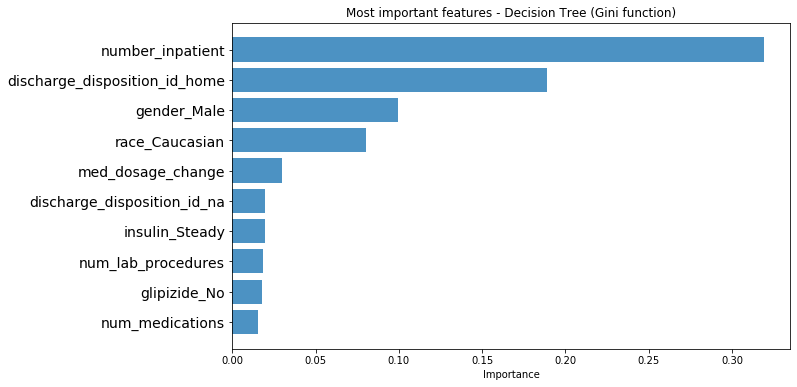

In [62]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dt_g.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree (Gini function)')
plt.show()

# Random Forest Classifier : "Gini"


In [63]:
# Data balancing applied using SMOTE
from imblearn.over_sampling import SMOTE

from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=20)
X_train_SMOTE_rf, y_train_SMOTE_rf = sm.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train_SMOTE_rf)))

Original dataset shape Counter({0: 51329, 1: 4486})
New dataset shape Counter({0: 51329, 1: 51329})


In [64]:
from sklearn.ensemble import RandomForestClassifier
rf_gini = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rf_gini.fit(X_train_SMOTE_rf, y_train_SMOTE_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
print("Train set Score: {:.3%}".format(rf_gini.score(X_train_SMOTE_rf, y_train_SMOTE_rf)))
print("Test Set score : {:.3%}".format(rf_gini.score(X_test, y_test)))

Train set Score: 96.043%
Test Set score : 90.154%


In [66]:
y_test_predict = rf_gini.predict(X_test)

In [67]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,19868,12,19880
1,2159,10,2169
All,22027,22,22049


In [68]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.90      1.00      0.95     19880
          1       0.45      0.00      0.01      2169

avg / total       0.86      0.90      0.86     22049



In [69]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

10 12 2159 19868


In [70]:
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.902
Precision is 0.455
Recall is 0.005
AUC is 0.502
TPR is 0.005
FPR is 0.001
TNR is 0.999


In [71]:
accuracy_rf_g = accuracy_score(y_test, y_test_predict)
precision_rf_g = precision_score(y_test, y_test_predict)
recall_rf_g = recall_score(y_test, y_test_predict)
auc_rf_g = roc_auc_score(y_test, y_test_predict)

TPR_rf_g=TPR
FPR_rf_g=FPR
TNR_rf_g=TNR

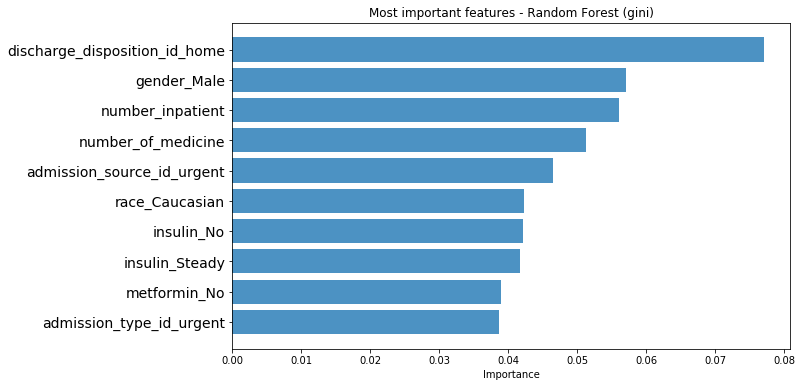

In [72]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rf_gini.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (gini)')
plt.show()

# Random Forest Classifier : "Entropy"


In [73]:
from sklearn.ensemble import RandomForestClassifier
rf_en = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "entropy", min_samples_split=10)
rf_en.fit(X_train_SMOTE_rf, y_train_SMOTE_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [74]:
print("Train set Score: {:.3%}".format(rf_en.score(X_train_SMOTE_rf, y_train_SMOTE_rf)))
print("Test Set score : {:.3%}".format(rf_en.score(X_test, y_test)))

Train set Score: 96.071%
Test Set score : 90.122%


In [75]:
y_test_predict = rf_en.predict(X_test)

In [76]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,19863,17,19880
1,2161,8,2169
All,22024,25,22049


In [77]:
report=classification_report(y_test, y_test_predict)
print(report)

             precision    recall  f1-score   support

          0       0.90      1.00      0.95     19880
          1       0.32      0.00      0.01      2169

avg / total       0.84      0.90      0.86     22049



In [78]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
print(tp, fp, fn, tn)  # 1 1 1 1

TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
TNR=tn/(fp+tn)

8 17 2161 19863


In [79]:
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision is {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall is {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC is {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
print("TPR is {0:.3f}".format(TPR))
print("FPR is {0:.3f}".format(FPR))
print("TNR is {0:.3f}".format(TNR))

Accuracy is 0.901
Precision is 0.320
Recall is 0.004
AUC is 0.501
TPR is 0.004
FPR is 0.001
TNR is 0.999


In [80]:
accuracy_rf_en = accuracy_score(y_test, y_test_predict)
precision_rf_en = precision_score(y_test, y_test_predict)
recall_rf_en = recall_score(y_test, y_test_predict)
auc_rf_en = roc_auc_score(y_test, y_test_predict)

TPR_rf_en=TPR
FPR_rf_en=FPR
TNR_rf_en=TNR

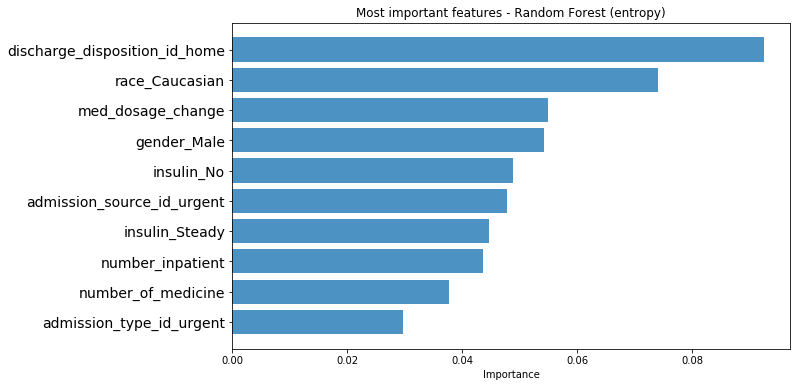

In [81]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rf_en.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (entropy)')
plt.show()